In [1]:
import numpy as np
import tensorflow as tf
from utils_functions import *
from plan import *
import random
from main import *
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.layers import LSTM
#from tensorflow.keras.layers import RepeatVector
#from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils  import plot_model
#from tensorflow.keras.utils  import Sequence
from sklearn.model_selection import train_test_split
import datetime, os
import pandas as pd

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# controllo di star effettivamente usando la GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print("nome gpu: ",tf.test.gpu_device_name())

## Preparazione dati

### Preparazione dati per struttura Simil-CBOW

Creazione dataset

In [18]:
dizionario_stati = load_file("./dizionario_stati")
piani_caricati = load_file("./plans")

File loaded
File loaded


In [2]:
#ESEMPIO DI TEST
d = [
    [[0,0,0,0],[0,0,0,1],[0,0,0,2],[0,0,0,3],[0,0,0,4],[0,0,0,5],[0,0,0,6],[0,0,0,7]],
    [[1,1,1,0],[1,1,1,1],[1,1,1,2],[1,1,1,3],[1,1,1,4],[1,1,1,5],[1,1,1,6],[1,1,1,7],[1,1,1,8],[1,1,1,9]],
    [[2,2,2,0],[2,2,2,1],[2,2,2,2],[2,2,2,3],[2,2,2,4]],
    [[3,3,3,0],[3,3,3,1],[3,3,3,2],[3,3,3,3]],
    [[4,4,4,0],[4,4,4,1],[4,4,4,2],[4,4,4,3],[4,4,4,4],[4,4,4,5]]

]

In [3]:
new = dataset_augmentation(d)

In [4]:
print(new)
print(new.shape)

[[[0 0 0 0]
  [0 0 0 1]
  [0 0 0 2]
  [0 0 0 3]
  [0 0 0 4]]

 [[1 1 1 0]
  [1 1 1 1]
  [1 1 1 2]
  [1 1 1 3]
  [1 1 1 4]]

 [[1 1 1 5]
  [1 1 1 6]
  [1 1 1 7]
  [1 1 1 8]
  [1 1 1 9]]

 [[2 2 2 0]
  [2 2 2 1]
  [2 2 2 2]
  [2 2 2 3]
  [2 2 2 4]]

 [[4 4 4 0]
  [4 4 4 1]
  [4 4 4 2]
  [4 4 4 3]
  [4 4 4 4]]]
(5, 5, 4)


# Processo creazione dateset corretti

In [19]:
dataset = costruisci_vettore_per_piano(dizionario_stati,piani_caricati)

dataset_5x340 = dataset_augmentation(dataset)

In [12]:
print(dataset_5x340.shape)

(256153, 5, 340)


In [59]:
np.random.shuffle(dataset_5x340)

In [68]:
df = pd.DataFrame(dataset_5x340.tolist(), columns=['s0', 's1','s2','s3','s4'])

In [74]:
df

,s0,s1,s2,s3,s4
0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ..."
4,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ..."
...,...,...,...,...,...
256148,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, ..."
256149,"[1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ..."
256150,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..."
256151,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [75]:
X=df[["s0","s1","s3","s4"]]

In [71]:
Y=df["s2"]

In [77]:
#split
x_tmp, x_test, y_tmp, y_test = train_test_split(X,Y,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x_tmp,y_tmp,test_size = 0.25,train_size =0.75)

In [80]:
x_train


,s0,s1,s3,s4
198651,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
31781,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
184357,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
122569,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, ..."
27869,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
...,...,...,...,...
255190,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
38072,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ..."
78506,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
118222,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ..."


In [81]:
y_train

198651    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
31781     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
184357    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
122569    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...
27869     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...
                                ...                        
255190    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
38072     [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...
78506     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
118222    [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...
230274    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
Name: s2, Length: 153691, dtype: object

In [82]:
x_test

,s0,s1,s3,s4
121870,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ..."
103691,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
707,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
232235,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
74661,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...
223598,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ..."
65876,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
190840,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
179598,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [83]:
y_test

121870    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...
103691    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...
707       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
232235    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
74661     [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...
                                ...                        
223598    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...
65876     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
190840    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...
179598    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
37477     [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...
Name: s2, Length: 51231, dtype: object

In [88]:
x_train=x_train.to_numpy(dtype=object)
y_train=y_train.to_numpy(dtype=object)

x_val=x_val.to_numpy(dtype=object)
y_val=y_val.to_numpy(dtype=object)

x_test=x_test.to_numpy(dtype=object)
y_test=y_test.to_numpy(dtype=object)


In [115]:
#Metodi usati per ri-trasformare tutti gli array/liste in np array con np.int8
def convert_x_np(data):
    new_data=[]
    for seq in data:
        new_seq=[]
        for array in seq:
            np_a=np.array(array,dtype=np.int8)
            new_seq.append(np_a)
        np_seq=np.array(new_seq)
        new_data.append(np_seq)
    np_new_data=np.array(new_data)
    return np_new_data  

def convert_y_np(data):
    new_data=[]
    for array in data:
        np_a=np.array(array,dtype=np.int8)
        new_data.append(np_a) 
               
    np_new_data=np.array(new_data)
    print("Completato")
    return np_new_data  


In [114]:
np_x_train=convert_x_np(x_train)
np_y_train=convert_y_np(y_train)

np_x_val=convert_x_np(x_val)
np_x_test=convert_x_np(x_test)

np_y_val=convert_y_np(y_val)
np_y_test=convert_y_np(y_test)

In [119]:
save_file(np_x_train, "./Dataset/", "set_training_x")
save_file(np_x_val, "./Dataset/", "set_validation_x")
save_file(np_x_test, "./Dataset/", "set_test_x")
    
save_file(np_y_train, "./Dataset/", "set_training_y")
save_file(np_y_val, "./Dataset/", "set_validation_y")
save_file(np_y_test, "./Dataset/", "set_test_y")

set_training_x saved in ./Dataset/
set_validation_x saved in ./Dataset/
set_test_x saved in ./Dataset/
set_training_y saved in ./Dataset/
set_validation_y saved in ./Dataset/
set_test_y saved in ./Dataset/


# Modello

Caricamento dataset

In [2]:
train_x=load_file("./Dataset/set_training_x")
train_y=load_file("./Dataset/set_training_y")
val_x=load_file("./Dataset/set_validation_x")
val_y=load_file("./Dataset/set_validation_y")
test_x=load_file("./Dataset/set_test_x")
test_y=load_file("./Dataset/set_test_y")

File loaded
File loaded
File loaded
File loaded
File loaded
File loaded


In [23]:
logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)

]



#PARAM:
#tf.keras.regularizers.L1(l1=1e-4)
param={"INPUT_SIZE" : "4,340" ,
"OUTPUT_SIZE":340,
"HIDDEN_SIZE" : 670,
"HIDDEN_SIZE2" : 134,
"HIDDEN_SIZE3" : None,
"CODE_SIZE" : 67,
"KERNEL_INIZIALIZER":"he_uniform",
"KERNEL_REGULIZER":tf.keras.regularizers.L2(l2=1e-5),
'BIAS_REGULARIZER': None,
"ACTIVATION":'relu',
"OPTIMIZER":tf.keras.optimizers.Adam(learning_rate=0.0002),
"EPOCHS":400,
"BATCH_SIZE":150,
"BATCH_NORMAIZATION": 0
}

autoencoderV2=tf.keras.models.Sequential()

autoencoderV2.add(Input(shape=(4,340)))

autoencoderV2.add(Flatten())

autoencoderV2.add( Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add(Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"],name="embedding"))

autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add(Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add( Dense(param["OUTPUT_SIZE"], activation='sigmoid'))


#variare learning_rate beta_1,beta_2, da fare per ultimo
#batch_size ???
autoencoderV2.compile(optimizer=param["OPTIMIZER"], loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
history=autoencoderV2.fit(x=train_x,y=train_y, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(val_x,val_y), 
                        callbacks=my_callbacks)

Epoch 1/400
1025/1025 [==============================] - 10s 9ms/step - loss: 0.1289 - accuracy: 0.0637 - precision: 0.7354 - recall: 0.4663 - val_loss: 0.0772 - val_accuracy: 0.0607 - val_precision: 0.8887 - val_recall: 0.7189
Epoch 2/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0671 - accuracy: 0.0469 - precision: 0.9079 - recall: 0.7683 - val_loss: 0.0610 - val_accuracy: 0.0384 - val_precision: 0.9187 - val_recall: 0.7957
Epoch 3/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0565 - accuracy: 0.0435 - precision: 0.9262 - recall: 0.8195 - val_loss: 0.0539 - val_accuracy: 0.0449 - val_precision: 0.9296 - val_recall: 0.8312
Epoch 4/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0512 - accuracy: 0.0451 - precision: 0.9359 - recall: 0.8433 - val_loss: 0.0501 - val_accuracy: 0.0474 - val_precision: 0.9388 - val_recall: 0.8443
Epoch 5/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0476 - accur

1025/1025 [==============================] - 7s 7ms/step - loss: 0.0213 - accuracy: 0.0656 - precision: 0.9841 - recall: 0.9672 - val_loss: 0.0242 - val_accuracy: 0.0541 - val_precision: 0.9778 - val_recall: 0.9570
Epoch 37/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0211 - accuracy: 0.0662 - precision: 0.9846 - recall: 0.9680 - val_loss: 0.0239 - val_accuracy: 0.0669 - val_precision: 0.9765 - val_recall: 0.9601
Epoch 38/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0209 - accuracy: 0.0671 - precision: 0.9848 - recall: 0.9688 - val_loss: 0.0239 - val_accuracy: 0.0617 - val_precision: 0.9755 - val_recall: 0.9597
Epoch 39/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0207 - accuracy: 0.0672 - precision: 0.9852 - recall: 0.9696 - val_loss: 0.0238 - val_accuracy: 0.0640 - val_precision: 0.9750 - val_recall: 0.9604
Epoch 40/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0204 - accuracy: 0.06

Epoch 72/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0165 - accuracy: 0.0851 - precision: 0.9908 - recall: 0.9821 - val_loss: 0.0198 - val_accuracy: 0.0792 - val_precision: 0.9816 - val_recall: 0.9728
Epoch 73/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0164 - accuracy: 0.0850 - precision: 0.9909 - recall: 0.9824 - val_loss: 0.0200 - val_accuracy: 0.0748 - val_precision: 0.9807 - val_recall: 0.9716
Epoch 74/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0163 - accuracy: 0.0849 - precision: 0.9910 - recall: 0.9825 - val_loss: 0.0195 - val_accuracy: 0.0822 - val_precision: 0.9816 - val_recall: 0.9745
Epoch 75/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0163 - accuracy: 0.0853 - precision: 0.9911 - recall: 0.9827 - val_loss: 0.0194 - val_accuracy: 0.0997 - val_precision: 0.9835 - val_recall: 0.9731
Epoch 76/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0162 - a

1025/1025 [==============================] - 7s 7ms/step - loss: 0.0145 - accuracy: 0.0978 - precision: 0.9929 - recall: 0.9867 - val_loss: 0.0179 - val_accuracy: 0.0873 - val_precision: 0.9840 - val_recall: 0.9773
Epoch 108/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0144 - accuracy: 0.0979 - precision: 0.9931 - recall: 0.9868 - val_loss: 0.0179 - val_accuracy: 0.1135 - val_precision: 0.9839 - val_recall: 0.9766
Epoch 109/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0144 - accuracy: 0.0978 - precision: 0.9931 - recall: 0.9868 - val_loss: 0.0178 - val_accuracy: 0.0939 - val_precision: 0.9841 - val_recall: 0.9777
Epoch 110/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0144 - accuracy: 0.0994 - precision: 0.9931 - recall: 0.9870 - val_loss: 0.0178 - val_accuracy: 0.0891 - val_precision: 0.9845 - val_recall: 0.9769
Epoch 111/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0143 - accuracy: 

Epoch 143/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0132 - accuracy: 0.1066 - precision: 0.9942 - recall: 0.9890 - val_loss: 0.0167 - val_accuracy: 0.1219 - val_precision: 0.9864 - val_recall: 0.9772
Epoch 144/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0132 - accuracy: 0.1070 - precision: 0.9942 - recall: 0.9890 - val_loss: 0.0166 - val_accuracy: 0.1030 - val_precision: 0.9850 - val_recall: 0.9800
Epoch 145/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0131 - accuracy: 0.1077 - precision: 0.9943 - recall: 0.9892 - val_loss: 0.0166 - val_accuracy: 0.0972 - val_precision: 0.9857 - val_recall: 0.9790
Epoch 146/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0131 - accuracy: 0.1111 - precision: 0.9942 - recall: 0.9892 - val_loss: 0.0165 - val_accuracy: 0.0945 - val_precision: 0.9857 - val_recall: 0.9797
Epoch 147/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.013

Epoch 179/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0123 - accuracy: 0.1184 - precision: 0.9949 - recall: 0.9905 - val_loss: 0.0156 - val_accuracy: 0.1312 - val_precision: 0.9874 - val_recall: 0.9805
Epoch 180/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0123 - accuracy: 0.1188 - precision: 0.9949 - recall: 0.9905 - val_loss: 0.0157 - val_accuracy: 0.1237 - val_precision: 0.9857 - val_recall: 0.9810
Epoch 181/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0123 - accuracy: 0.1191 - precision: 0.9949 - recall: 0.9905 - val_loss: 0.0156 - val_accuracy: 0.1226 - val_precision: 0.9868 - val_recall: 0.9806
Epoch 182/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0122 - accuracy: 0.1184 - precision: 0.9950 - recall: 0.9906 - val_loss: 0.0156 - val_accuracy: 0.1023 - val_precision: 0.9880 - val_recall: 0.9799
Epoch 183/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.012

Epoch 215/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0116 - accuracy: 0.1255 - precision: 0.9954 - recall: 0.9914 - val_loss: 0.0150 - val_accuracy: 0.1075 - val_precision: 0.9877 - val_recall: 0.9813
Epoch 216/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0116 - accuracy: 0.1231 - precision: 0.9954 - recall: 0.9915 - val_loss: 0.0149 - val_accuracy: 0.1389 - val_precision: 0.9877 - val_recall: 0.9822
Epoch 217/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0116 - accuracy: 0.1263 - precision: 0.9954 - recall: 0.9914 - val_loss: 0.0149 - val_accuracy: 0.1076 - val_precision: 0.9866 - val_recall: 0.9823
Epoch 218/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0115 - accuracy: 0.1264 - precision: 0.9955 - recall: 0.9917 - val_loss: 0.0151 - val_accuracy: 0.1432 - val_precision: 0.9864 - val_recall: 0.9816
Epoch 219/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.011

Epoch 251/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0111 - accuracy: 0.1311 - precision: 0.9957 - recall: 0.9920 - val_loss: 0.0144 - val_accuracy: 0.1527 - val_precision: 0.9877 - val_recall: 0.9828
Epoch 252/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0110 - accuracy: 0.1324 - precision: 0.9959 - recall: 0.9923 - val_loss: 0.0146 - val_accuracy: 0.1451 - val_precision: 0.9870 - val_recall: 0.9821
Epoch 253/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0110 - accuracy: 0.1341 - precision: 0.9957 - recall: 0.9921 - val_loss: 0.0145 - val_accuracy: 0.1040 - val_precision: 0.9878 - val_recall: 0.9820
Epoch 254/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0110 - accuracy: 0.1320 - precision: 0.9958 - recall: 0.9922 - val_loss: 0.0144 - val_accuracy: 0.1366 - val_precision: 0.9863 - val_recall: 0.9838
Epoch 255/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.011

In [24]:
autoencoderV2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1360)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 670)               911870    
_________________________________________________________________
dense_26 (Dense)             (None, 134)               89914     
_________________________________________________________________
embedding (Dense)            (None, 67)                9045      
_________________________________________________________________
dense_27 (Dense)             (None, 134)               9112      
_________________________________________________________________
dense_28 (Dense)             (None, 670)               90450     
_________________________________________________________________
dense_29 (Dense)             (None, 340)              

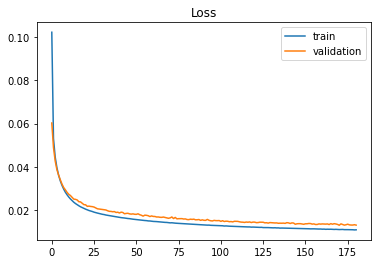

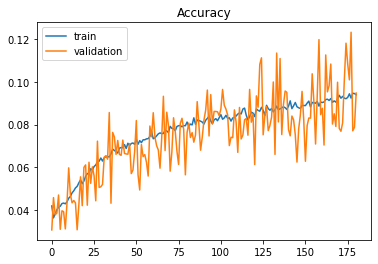

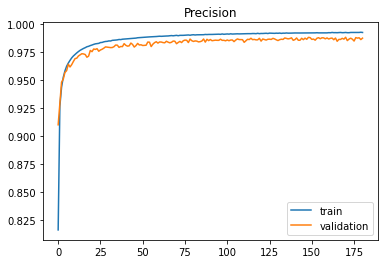

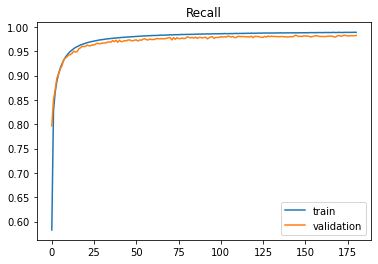

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss")
plt.show()
    
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.legend()
plt.title("Precision")
plt.show()

plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.legend()
plt.title("Recall")
plt.show()

In [25]:
y_test_predict= autoencoderV2.predict(test_x)


Numero di vettori decodificati correttamente: 41432 su 51231 totali 
Rapporto: 80.873% 
Media num di errori per array: 0.483



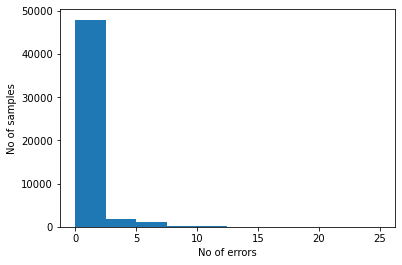

In [26]:
arr=results_info(test_y, y_test_predict,logdir)


In [ ]:
#Se è buono salvare (>90% rapporto vettori decodificati correttamente)

dir_model= os.path.join(logdir,"myModel")
autoencoderV2.save(dir_model)